# Fraud Audit & Bankruptcy Data Science Assignment

**Submitted by: Nick De Marchi**

# Contents:

[**Section 1: Fraud Audit**](#section-1-fraud-audit)

1. [Check and Clean Data](#check-and-clean-data)

2. [Brief EDA](#brief-eda)

3. [Choosing ML Model](#choosing-ml-model)
    - [Model 1: Random Forest with Hyperparameter Tuning](#RF)
    - [Model 2: XGBoost with Hyperparameter Tuning](#XGBoost)
    - [Model 3: Artifical Neural Network with Callbacks](#ANN)
    
[**Section 2: Predicting Bankruptcy**](#section-1-predicting-bankruptcy)

1. [Load and Encode Data](#load-and-encode-data)
2. [Building ML Model](#building-ml-model)
    - [Model 1: Random Forest](#random-forest)
    - [Model 2: Logistic Regression with Threshold](#logistic-regression)
    

In [1]:
## General packages
import numpy as np
import scipy as sp
import pandas as pd

### Data visualization packages
import matplotlib.pyplot as plt
from IPython.display import display, Image
import seaborn as sns

# AI/ML toolkit
import tensorflow as tf # For neural network model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # callbacks
from sklearn.preprocessing import StandardScaler, MinMaxScaler # to standardize/normalize
from sklearn.impute import KNNImputer # To impute NaN's
from sklearn.ensemble import RandomForestClassifier # First classification algorithm
from sklearn.linear_model import LogisticRegression # Second classification algorithm
from xgboost import XGBClassifier # Third classification algorithm

# Some functions for testing model
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     RepeatedStratifiedKFold, 
                                     RandomizedSearchCV)
# To test classification algorithms
from sklearn.metrics import confusion_matrix,classification_report

# Filter warning
import warnings
warnings.filterwarnings('ignore')

## Section 1: Fraud Audit
**------------------------------------------**

In [2]:
# read in fraud audit dataset
fraud_path = '/Users/prometheus/Downloads/2022-11-25_DS_Interview_Assignment/fraud_audit/'
df = pd.read_csv(fraud_path+'audit_risk_data.csv')

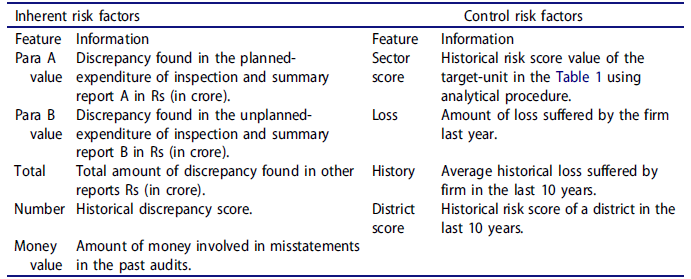

In [3]:
# Displaying the description of each variable for reference
im = fraud_path+'Table_1_Features.png'
display(Image(filename=im))

# 1. Check and Clean Data 
In this step I find that we have one NaN value for the *Money_Value* column. I decide to use a simple KNN Imputer to fill that value by clustering neighbours in the dataset and filling the missing value with the mean value of it's 5 closest neighbours. However, before I do this, I also notice that in *LOCATION_ID* we have 43 values as **integer** (ranging from 1 --> 44, with 10 missing) and 3 as **object** ('LOHARU','NUH','SAFIDON'). Therefore, I will give 'LOHARU' ID = 10, 'NUH' ID=45 and 'SAFIDON' ID=46. 

**Note:** I will drop the LOCATION_ID column later, but will maintain it for now. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   LOCATION_ID    776 non-null    object 
 2   PARA_A         776 non-null    float64
 3   PARA_B         776 non-null    float64
 4   numbers        776 non-null    float64
 5   Money_Value    775 non-null    float64
 6   District_Loss  776 non-null    int64  
 7   History        776 non-null    int64  
 8   Score          776 non-null    float64
 9   Risk           776 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 60.8+ KB


In [5]:
# display where we have missing value(s)
row, col = np.where(df.isna())[0], np.where(df.isna())[1]
print('We have missing value(s) in: \nColumn -->', df.columns[col][0], '\nRow -->', row[0])

We have missing value(s) in: 
Column --> Money_Value 
Row --> 642


In [6]:
# data type mismatch for LOCATION ID
print(sorted(df.LOCATION_ID.unique()))

['1', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '5', '6', '7', '8', '9', 'LOHARU', 'NUH', 'SAFIDON']


In [7]:
# first change the ID's
df = df.replace(['LOHARU', 'NUH', 'SAFIDON'], [10,45,46])

In [8]:
# apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(df)
arr = imputer.transform(df)
df = pd.DataFrame(arr, columns = df.columns, index = df.index)

In [9]:
# we no longer have missing values and our datatypes match
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   LOCATION_ID    776 non-null    float64
 2   PARA_A         776 non-null    float64
 3   PARA_B         776 non-null    float64
 4   numbers        776 non-null    float64
 5   Money_Value    776 non-null    float64
 6   District_Loss  776 non-null    float64
 7   History        776 non-null    float64
 8   Score          776 non-null    float64
 9   Risk           776 non-null    float64
dtypes: float64(10)
memory usage: 60.8 KB


In [10]:
# We have 3 categories that were type (int). Convert back
df.District_Loss = df.District_Loss.astype(int)
df.History = df.History.astype(int)
df.Risk = df.Risk.astype(int)

In [11]:
# Display first 5 and last 5 rows of dataset
df

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
0,3.89,23.0,4.18,2.50,5.0,3.38,2,0,2.4,1
1,3.89,6.0,0.00,4.83,5.0,0.94,2,0,2.0,0
2,3.89,6.0,0.51,0.23,5.0,0.00,2,0,2.0,0
3,3.89,6.0,0.00,10.80,6.0,11.75,2,0,4.4,1
4,3.89,6.0,0.00,0.08,5.0,0.00,2,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...
771,55.57,9.0,0.49,0.40,5.0,0.00,2,0,2.0,0
772,55.57,16.0,0.47,0.37,5.0,0.00,2,0,2.0,0
773,55.57,14.0,0.24,0.04,5.0,0.00,2,0,2.0,0
774,55.57,18.0,0.20,0.00,5.0,0.00,2,0,2.0,0


# 2. Brief EDA
Explore some of the distributions for our variables and correlations

In [12]:
df.describe()

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,14.929124,2.450194,10.799988,5.067655,14.119425,2.505155,0.104381,2.702577,0.393041
std,24.319017,9.995425,5.678870,50.083624,0.264449,66.565465,1.228678,0.531031,0.858923,0.488741
min,1.850000,1.000000,0.000000,0.000000,5.000000,0.000000,2.000000,0.000000,2.000000,0.000000
25%,2.370000,8.000000,0.210000,0.000000,5.000000,0.000000,2.000000,0.000000,2.000000,0.000000
50%,3.890000,13.000000,0.875000,0.405000,5.000000,0.090000,2.000000,0.000000,2.400000,0.000000
75%,55.570000,19.000000,2.480000,4.160000,5.000000,5.587500,2.000000,0.000000,3.250000,1.000000
max,59.850000,46.000000,85.000000,1264.630000,9.000000,935.030000,6.000000,9.000000,5.200000,1.000000


In [13]:
# Defining a combined boxplot plus histogram function
def hist_box(data, col):
    '''
    paramaters:
    -----------
        data (pandas.DataFrame): The dataframe input
        col (String): The column from data we wish to call
    Returns:
    --------
        Combined boxplot and histogram
    '''
    
    f, (ax_box, ax_hist) = plt.subplots(2, 
                                        sharex=True, 
                                        gridspec_kw={'height_ratios': (0.15, 0.85)}, 
                                        figsize=(8,5))
    
    sns.boxplot(x = data[col], ax=ax_box, showmeans=True)
    sns.distplot(data[col], ax=ax_hist, bins = 45)
    # Adding verticle mean/median lines to distplot to match up with boxplot mean/median
    ax_hist.axvline(data[col].median(), c='k', linestyle = 'dashed', label = 'median')
    ax_hist.axvline(data[col].mean(), c = 'g', linestyle = 'dashed', label = 'mean')
    ax_hist.legend(loc = 0, frameon = False, labelcolor = 'linecolor', fontsize = 15)
    # adjustement of label and label size
    ax_hist.set_xlabel(col, fontsize = 14)
    ax_hist.set_ylabel('Density', fontsize = 14)
    plt.show()
    plt.close()
    print(20*'*'+'End of Box+Hist plot for '+ str(col)+20*'*')

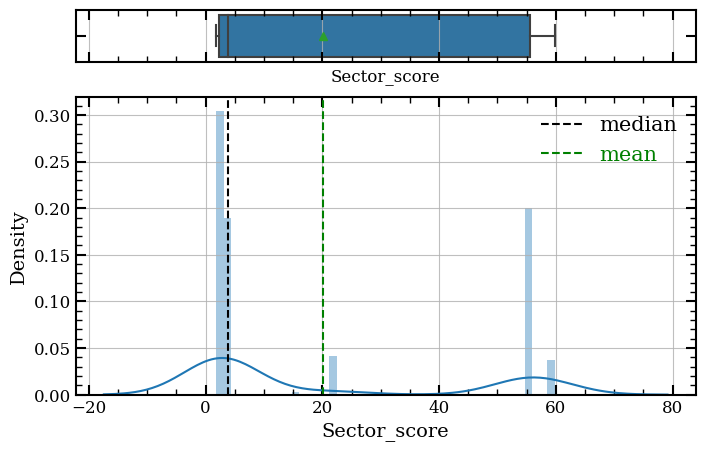

********************End of Box+Hist plot for Sector_score********************


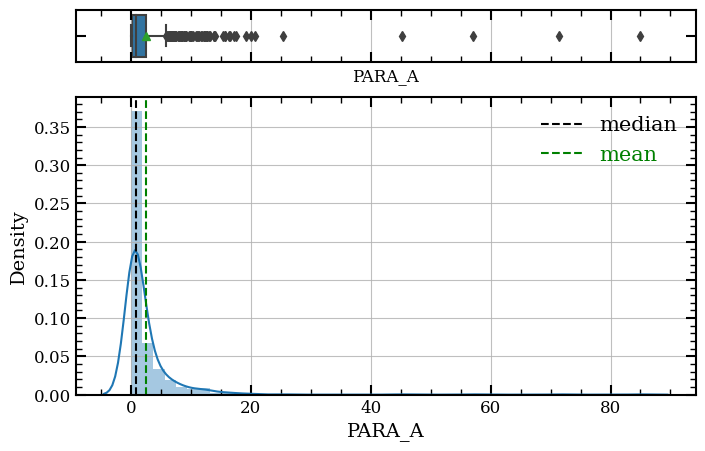

********************End of Box+Hist plot for PARA_A********************


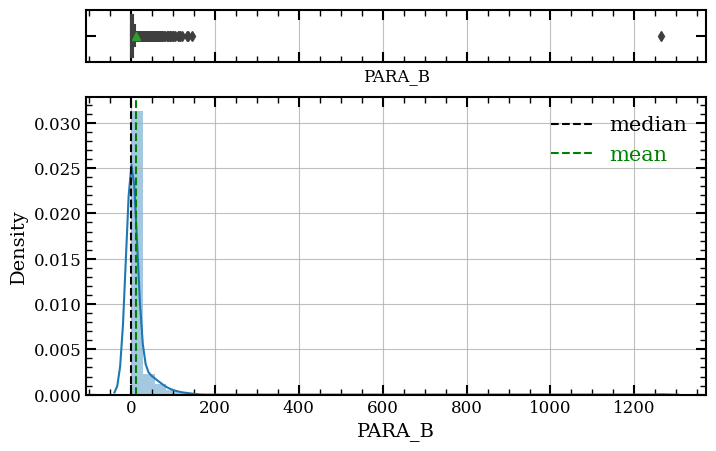

********************End of Box+Hist plot for PARA_B********************


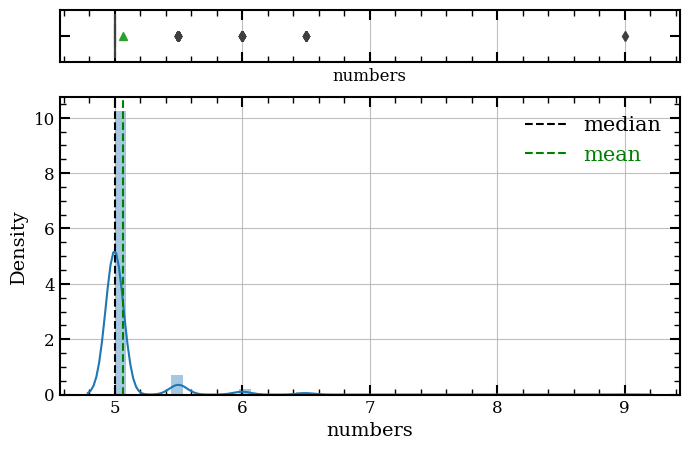

********************End of Box+Hist plot for numbers********************


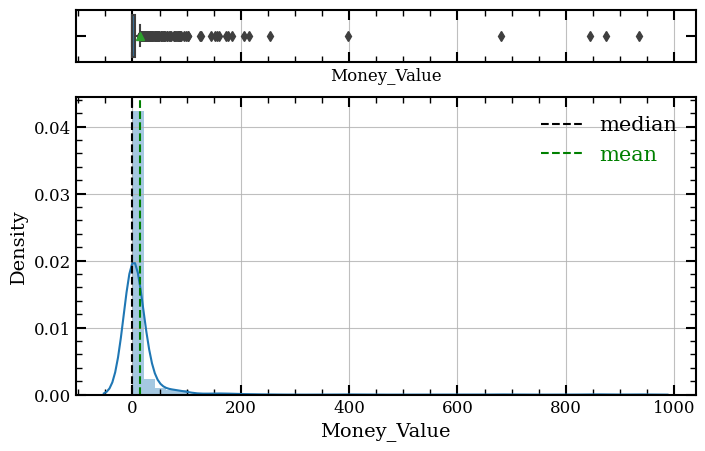

********************End of Box+Hist plot for Money_Value********************


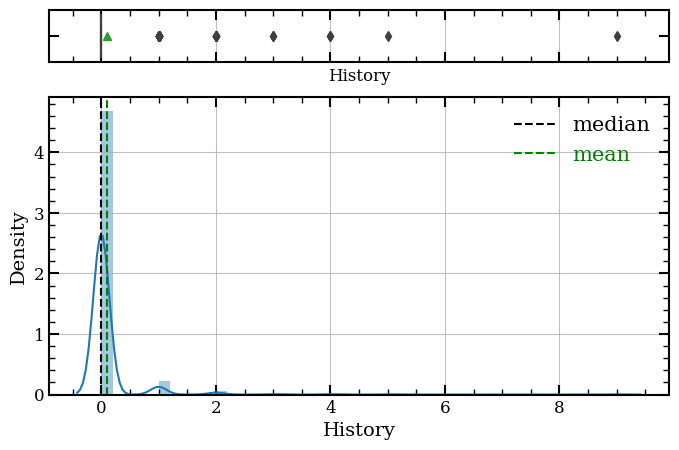

********************End of Box+Hist plot for History********************


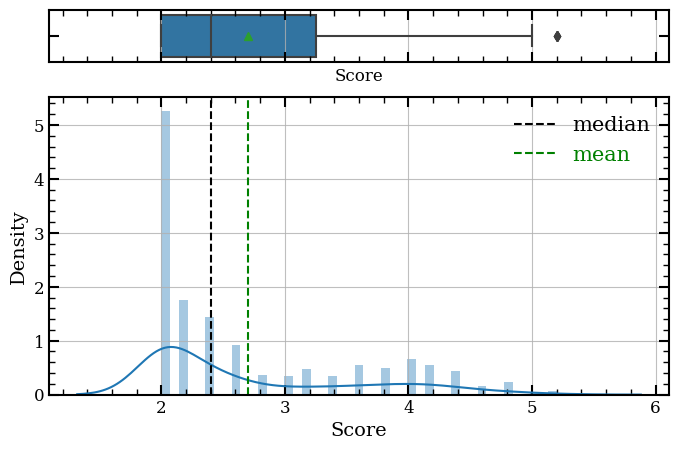

********************End of Box+Hist plot for Score********************


In [14]:
## Sorry about the scroll here in the display, I did not want to take up much space. 
## If you want to see the distributions all at once one can uncomment and run the next cell
eval_cols = ['Sector_score', 'PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'History', 'Score']
for col in eval_cols:
    hist_box(df, col)

Glancing over the above plots and the printed statistics there are mainly skewed distributions with outliers (such and PARA_A, PARA_B, Money_Value, Score and History) along with discrete distribution (Numbers). Taking a look at 'PARA_B' for instance, we notice that $(min, max) \rightarrow (0,1264.63)$ with a large standard deviation $(\pm 50.1)$, however, our median $( \mu = 10.8)$ is closer to the minimum in the dataset so we have a right skewed distribution as shown above. We will use a normalizer (rather than standarizer) on our data since we do not have noticable guassian-like distributions for all variables.

In [15]:
##### (Optional) Uncomment below ######
#df[eval_cols].hist(bins = 45, figsize=(18,12))
#plt.show()

<AxesSubplot:>

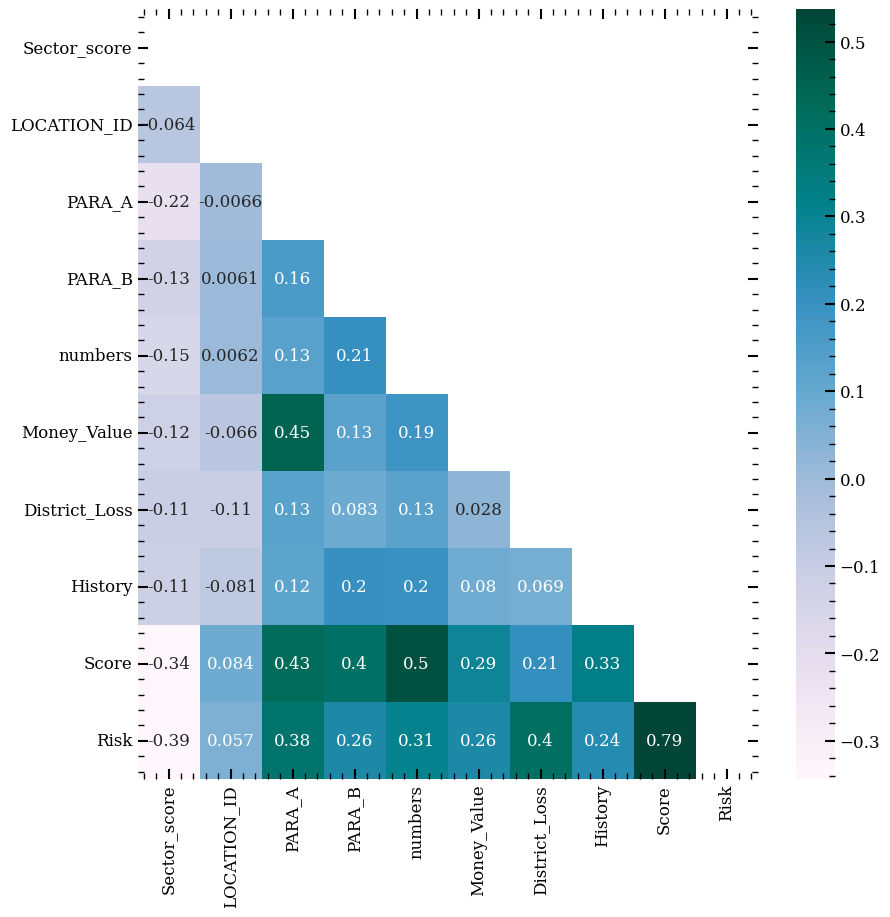

In [16]:
# Correlation plot. Keep values under diagonal. 
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot=True, cmap = 'PuBuGn', robust = True, mask = mask)

We notice a few moderate-to-strong correlations between **Score, Loss & PARA_A** with **Risk**. **Money Value** and **PARA_A** also seem to be correlated, along with **Score** with **PARA_A, PARA_B & numbers**. 

# 3. Choosing ML Model

Before training, I will first drop the *LOCATION_ID* parameter as this is not correlated with anything and just a placeholder variable. I will then normalize our features and then split the data into training and validation sets to test generalization of our model.

In [17]:
# drop LOCATION_ID
df = df.drop('LOCATION_ID', axis = 1)

# Normalize
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns = df.columns)

# Features and Target variable
X = scaled_df.drop(['Risk'], axis=1)
Y = scaled_df['Risk']

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.30,
                                                    stratify=Y, 
                                                    random_state=42)

### Model 1: Random Forest using Train-Test Split & Hyperparameter Tuning

In [18]:
# get weights for probabaility of each outcome
class1_weight = sum(Y) / Y.shape[0]
class0_weight = 1 - class1_weight

# define the model
rf = RandomForestClassifier(class_weight = {0: class0_weight, 1: class1_weight}, 
                            random_state = 42)

# some hyperp-parameters to tune
random_grid = {'bootstrap': [True,False],
               'max_features': ['sqrt', 'log2', None],
               'min_samples_leaf': [1,2,3],
               'min_samples_split': [2,3,4],
               'oob_score': [True,False]}


# Search optimal a set of parameters from my grid
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 200, 
                               cv = 3, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 0.606958762886598,
                                                                  1: 0.39304123711340205},
                                                    random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4],
                                        'oob_score': [True, False]},
                   random_state=42)

### **Note:** 
We may also use k-fold cross-validation to test the generalization of our model where we take the average of K-predictions from K test samples. I have commented this and included it below, however, I have chosen to defne my own scoring metric based on scikit-learn's specific classification_report function and visualize with a confusion matrix. 

In [19]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
#n_scores = cross_val_score(rf, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

My metric score function

In [20]:
# Creating metric function 
def metrics_score(actual, predicted, primary_label = '1', secondary_label = '0' ):
    '''
    Parameters:
    -----------
        actual (array): the true y-value
        predicted (array): The predicted y-value by our model
        primary_label (string): Class we wish to predict. Default is '1'.
        secondary_label (string): The other class in our dataset. Default is '0'.
    Return:
    -------
        The classification report (precision, recall and accuracy) along with
        a confusion matrix for our predictions.
    '''
    print(classification_report(actual, predicted, digits=3))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, 
                annot=True,  
                fmt='.2f', 
                cmap='Blues', 
                xticklabels=[primary_label+'(1)', secondary_label+'(0)'], 
                yticklabels=[primary_label+'(1)', secondary_label+'(1)'],
                cbar_kws={'label': 'Number of predictions'},
               )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

         0.0      0.993     0.993     0.993       141
         1.0      0.989     0.989     0.989        92

    accuracy                          0.991       233
   macro avg      0.991     0.991     0.991       233
weighted avg      0.991     0.991     0.991       233



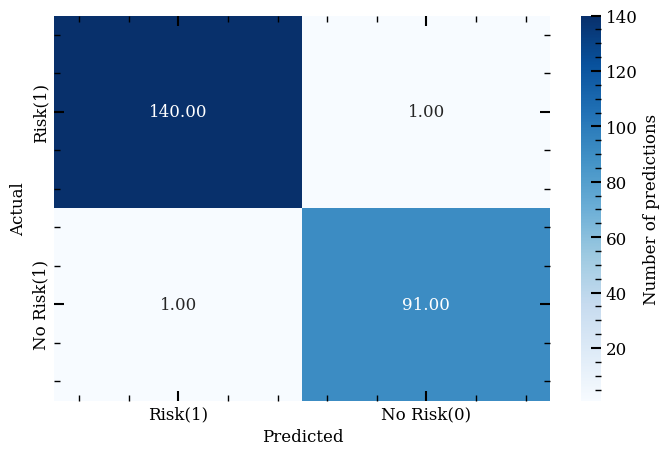

In [21]:
# get the best estimator, predict and score.
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(X_test)
metrics_score(y_test, y_pred, 'Risk', 'No Risk')

As we can see, our tuned Random Forest Classifier is predicting Risk in our test dataset to ~ 99.1% accuracy. This is pretty good for a relatively simple hyper-parameter tuning.

### Model 2: XGBoost with Hyperparameter Tuning
I will now compare against the Extreme Gradient Boost algorithm and use the XGB Classifier model. I will also run some simple hyper parameter tuning.

In [22]:
# XGBoost model
xgb = XGBClassifier(objective = 'binary:logistic', use_label_encoder=False, random_state=42)

# Grid
random_grid = {'n_estimators':[10,50,100,200,500],
               'eta': [0.001,0.1,0.2,0.3],
               'gamma': [0,1,2],
               'max_depth': [3,4,5],
               'colsample_bytree': [0.5, 0.8],
               'booster':['gbtree', 'dart'],
               'eval_metric':['auc', 'rmse', 'logloss'],
               'tree_method':['hist', 'exact', 'approx'],
               'grow_policy':['lossguide']}

# Randomly search parameters from grid
xgb_random = RandomizedSearchCV(estimator = xgb,
                                param_distributions = random_grid, 
                                n_iter = 300, 
                                cv = 4, 
                                random_state=42, 
                                n_jobs = -1)
# Fit
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'colsample_bytree': [0.5, 0.8],
                                        'eta': [0.001, 0.1, 0.2, 0.3],
                                        'eval_metric': ['auc', 'rmse',
                                                        'logloss'],
                                        'gamma': [0, 1, 2],
                                        'grow_policy': ['lossguide'],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [10, 50, 100, 200, 500],
                                        'tree_method': ['hist', 'exact',
                                                        'approx']},
                   random_state=42)

              precision    recall  f1-score   support

         0.0      0.986     0.986     0.986       141
         1.0      0.978     0.978     0.978        92

    accuracy                          0.983       233
   macro avg      0.982     0.982     0.982       233
weighted avg      0.983     0.983     0.983       233



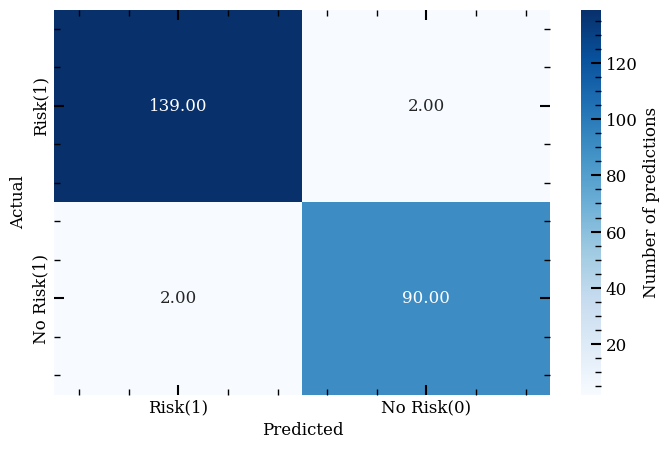

In [23]:
# Get best model, predict and score
xgb_best = xgb_random.best_estimator_
y_pred = xgb_best.predict(X_test)
metrics_score(y_test, y_pred, 'Risk', 'No Risk')

Our tuned Random Forest (99.1%) is currently performing a bit better than XGBoost (98.3%). I will try one more method and build a artificial neural network with sigmoid output layer. I do not expect a neural network to perform optimally given the sparse data we are feeding it but figure I would give it a try to compare.

Our model includes the following features:

1. Input layer
2. Three hidden Dense layers with two ReLu and one softmax activations and regularization.
3. Batch normalization and dropout for each layer (besides ouput)
3. Output layer with sigmoid activation for binary classification
4. RMSprop optimizer
5. Binary cross-entropy loss function
6. Callbacks to prevent overfitting (reducing learning rate on plateau and early stopping is used)
7. Batch sizes of 60, fast training
8. 200 epochs

In [24]:
# define regularization techniques
def regularization(lmb=0.001, regularization=None):
    '''
    Parameters:
    -----------
        lmb (float): The lambda coefficient for LASSO & Ridge regularizer.
                     This can range from 0 --> inf with typical values between
                     0 and0.1. Larger values bring coefficients closer to zero 
                     faster. Default is 0.001
        regularization (string): The regularization technique we wish to use.
                                 Our options are 'L1'(LASSO), 'L2'(Ridge) or a 
                                 combination of the two 'L1L2'.
    Returns:
    --------
        kernel_regularization technique for Tensorflow Sequential layer
    '''
    
    if regularization is not None:
        if regularization == 'L1':
            reg = tf.keras.regularizers.L1(lmb)
        elif regularization == 'L2':
            reg = tf.keras.regularizers.L2(lmb)
        elif regularization == 'L1L2':
            reg = tf.keras.regularizers.L1L2(lmb)
        else:
            raise ValueError("Regularizer must be 'L1','L2' or 'L1L12'.")
        return reg
    else:
        return None

In [25]:

input_shape = X_train.shape[1]

# very subtle regularization
reg = regularization(0.0001, 'L1L2')

model = tf.keras.models.Sequential(
    [
    
    #input
    tf.keras.layers.BatchNormalization(input_shape=[input_shape]),
    
    # hidden layers
        
    tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
        
    tf.keras.layers.Dense(4, activation = 'softmax', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    # output
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
    
    ]
)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, 
              loss="binary_crossentropy", 
              metrics=["accuracy"])

# hyperparams
earlystop = EarlyStopping(patience=40) 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

model.summary()

epochs=200 
history = model.fit(X_train, 
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=60,
                    epochs=epochs,
                    callbacks=callbacks,
                   )

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 batch_normalization_2 (Ba

2022-11-27 23:50:42.653236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 23:50:42.653396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-27 23:50:42.844766: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 23:50:43.287614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 70ms/step - loss: 0.4350 - accuracy: 0.8600 - val_loss: 0.6388 - val_accuracy: 0.6137 - lr: 0.0100
Epoch 2/200


2022-11-27 23:50:44.251172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 20ms/step - loss: 0.2516 - accuracy: 0.9521 - val_loss: 0.6069 - val_accuracy: 0.6137 - lr: 0.0100
Epoch 3/200
10/10 [==============================] - 0s 17ms/step - loss: 0.2387 - accuracy: 0.9448 - val_loss: 0.6017 - val_accuracy: 0.6052 - lr: 0.0100
Epoch 4/200
10/10 [==============================] - 0s 17ms/step - loss: 0.2539 - accuracy: 0.9392 - val_loss: 0.6062 - val_accuracy: 0.6052 - lr: 0.0100
Epoch 5/200
10/10 [==============================] - 0s 17ms/step - loss: 0.2266 - accuracy: 0.9484 - val_loss: 0.6009 - val_accuracy: 0.6094 - lr: 0.0100
Epoch 6/200
10/10 [==============================] - 0s 17ms/step - loss: 0.2105 - accuracy: 0.9484 - val_loss: 0.6120 - val_accuracy: 0.6309 - lr: 0.0100
Epoch 7/200
10/10 [==============================] - 0s 16ms/step - loss: 0.2343 - accuracy: 0.9392 - val_loss: 0.6187 - val_accuracy: 0.6481 - lr: 0.0100
Epoch 8/200
10/10 [==============================] - 0s 17ms/step - loss: 0.2350 -

10/10 [==============================] - 0s 16ms/step - loss: 0.1575 - accuracy: 0.9540 - val_loss: 0.1336 - val_accuracy: 0.9871 - lr: 3.1250e-04
Epoch 101/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1662 - accuracy: 0.9632 - val_loss: 0.1320 - val_accuracy: 0.9871 - lr: 3.1250e-04
Epoch 102/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1702 - accuracy: 0.9558 - val_loss: 0.1316 - val_accuracy: 0.9871 - lr: 3.1250e-04
Epoch 103/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.1872 - accuracy: 0.9556
Epoch 103: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
10/10 [==============================] - 0s 16ms/step - loss: 0.1893 - accuracy: 0.9540 - val_loss: 0.1312 - val_accuracy: 0.9871 - lr: 3.1250e-04
Epoch 104/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1706 - accuracy: 0.9576 - val_loss: 0.1335 - val_accuracy: 0.9871 - lr: 1.5625e-04
Epoch 105/200
10/10 [==========================

10/10 [==============================] - 0s 16ms/step - loss: 0.1567 - accuracy: 0.9705 - val_loss: 0.1330 - val_accuracy: 0.9828 - lr: 1.0000e-05
Epoch 147/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1518 - accuracy: 0.9613 - val_loss: 0.1340 - val_accuracy: 0.9828 - lr: 1.0000e-05
Epoch 148/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1503 - accuracy: 0.9705 - val_loss: 0.1351 - val_accuracy: 0.9828 - lr: 1.0000e-05
Epoch 149/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1682 - accuracy: 0.9576 - val_loss: 0.1348 - val_accuracy: 0.9828 - lr: 1.0000e-05
Epoch 150/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1575 - accuracy: 0.9632 - val_loss: 0.1356 - val_accuracy: 0.9871 - lr: 1.0000e-05
Epoch 151/200
10/10 [==============================] - 0s 16ms/step - loss: 0.1477 - accuracy: 0.9669 - val_loss: 0.1364 - val_accuracy: 0.9871 - lr: 1.0000e-05
Epoch 152/200
10/10 [===========================

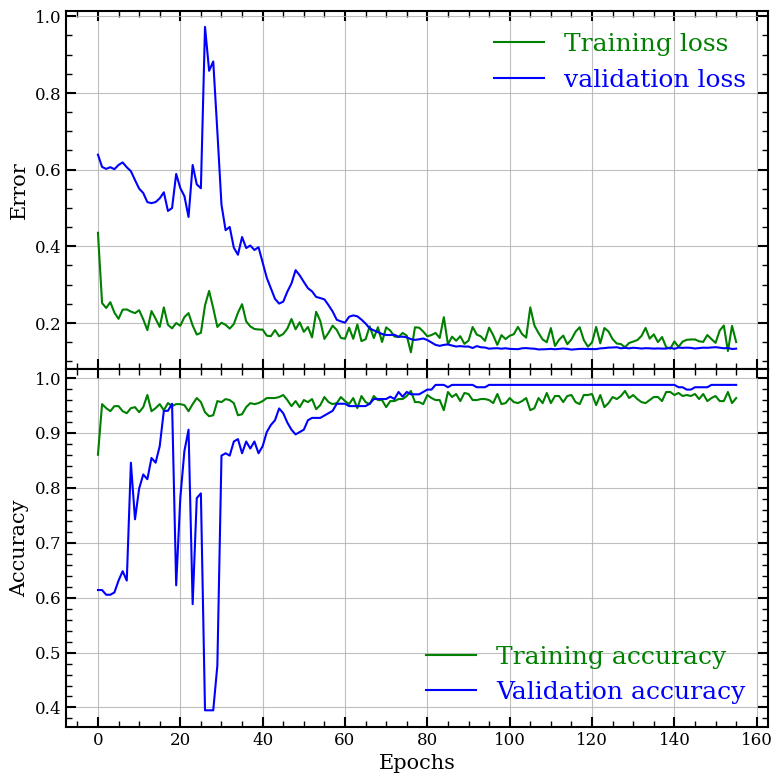

In [26]:
# plot loss and accuracy
gridspec_kw = dict(height_ratios=(1, 1), hspace=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw=gridspec_kw)

ax1.plot(history.history['loss'], color='g', label="Training loss")
ax1.plot(history.history['val_loss'], color='b', label="validation loss")
ax1.set_ylabel('Error', fontsize = 15)
ax1.legend(loc='best', frameon = False, labelcolor = 'linecolor', fontsize = 18)

ax2.plot(history.history['accuracy'], color='g', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
ax2.set_xlabel('Epochs', fontsize = 15)
ax2.set_ylabel('Accuracy', fontsize = 15)
ax2.legend(loc='best', frameon = False, labelcolor = 'linecolor', fontsize = 18)

plt.tight_layout()
plt.show()

Ultimately, we got out valdiation accuracy to ~99% with the neural network and loss to ~0.1. We can of course play around with the model to imporve this but for now I will stick with the **tuned Random Forest model as our best model for this problem**.

Lastly, from our Random Forest model, our important features are:

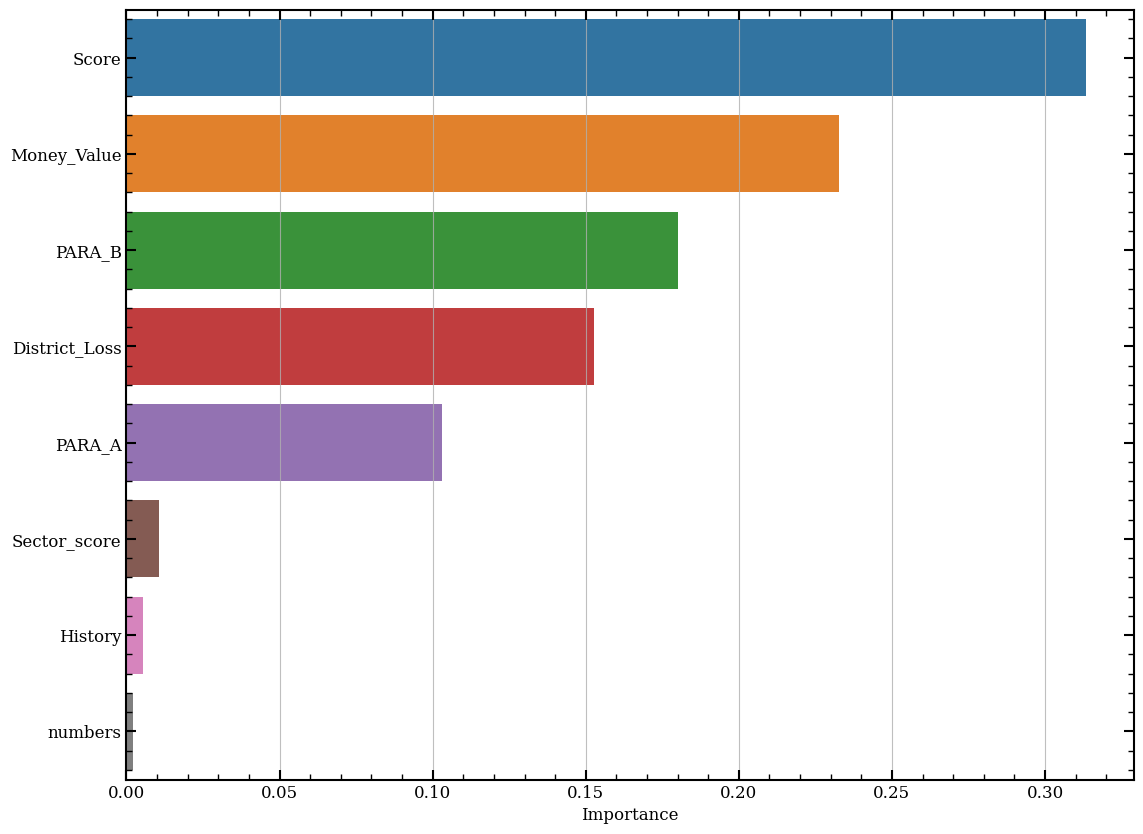

In [27]:
importances = rf_best.feature_importances_
columns = X.columns

importance_df_temp = pd.DataFrame(importances, 
                                  index = columns, 
                                  columns = ['Importance'])

importance_df = importance_df_temp.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 10))
sns.barplot(x = importance_df.Importance, y = importance_df.index)
plt.show()

We see that **Score, Money Value** and **PARA B** are our most important features in predicting our Risk.

# Section 2: Predicting Bankruptcy 

**------------------------------------------------------------------------**

## 1. Load and Encode Data

For this dataset, we have 6 features to predict the classification of bankruptcy (binary). Our features are rank categorical for Industrial risk, Managment risk, Financial flexibility, competativness and operating risk. I will encode our features and target variable to solve. 

In [28]:
# read in fraud audit dataset
quant_path = '/Users/prometheus/Downloads/2022-11-25_DS_Interview_Assignment/qualitative_banking/Qualitative_Bankruptcy.data.txt'
df = pd.read_csv(quant_path, sep = ",", header = None)
df.columns = ['Industrial_Risk', 
              'Management_Risk', 
              'Financial_Flexibility',
              'Credibility',
              'Competitiveness',
              'Operating_Risk',
              'Class',
             ]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Industrial_Risk        250 non-null    object
 1   Management_Risk        250 non-null    object
 2   Financial_Flexibility  250 non-null    object
 3   Credibility            250 non-null    object
 4   Competitiveness        250 non-null    object
 5   Operating_Risk         250 non-null    object
 6   Class                  250 non-null    object
dtypes: object(7)
memory usage: 13.8+ KB


In [29]:
# I am going to manually encode categorical data since there is a rank.
df = df.replace(['P', 'A', 'N'], [3,2,1])
df = df.replace(['NB', 'B'], [0,1])

## 2. Building Predictive Model

### Model 1: Random Forest

I will start with a **Random Forest Classification** algorithm again. This algorithm is usually a good starting point out of the box for many classification problems and we are less prone to overfitting comapred to other desicion trees based algorithms.

In [30]:
# Seperate features and class
X = df.drop(['Class'], axis = 1)
y = df.Class

# Splitting data in train and test sets to guage generalization
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.35,
                                                    stratify=y, 
                                                    random_state=42)

In [31]:
# Calculate weights for our binary classification variable since we are not uniform.
class1_weight = sum(y) / y.shape[0]
class0_weight = 1 - class1_weight

# define the model
rf = RandomForestClassifier(class_weight = {0: class0_weight, 1: class1_weight}, 
                            random_state = 42)

# train model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5720000000000001, 1: 0.428},
                       random_state=42)

Use my metric score function to evaluate performance

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        93
           1      1.000     1.000     1.000        69

    accuracy                          1.000       162
   macro avg      1.000     1.000     1.000       162
weighted avg      1.000     1.000     1.000       162



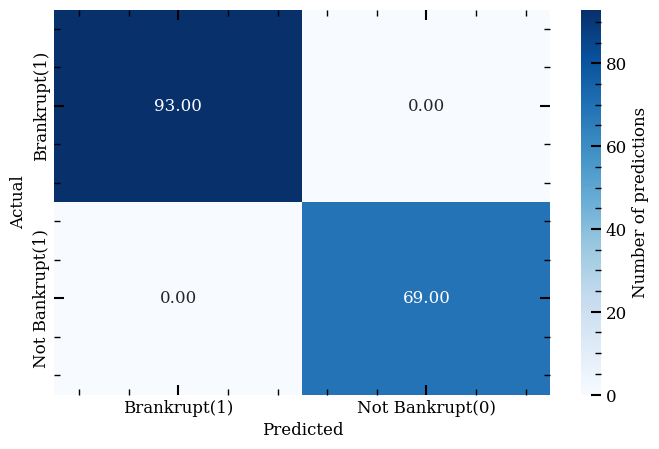

In [32]:
# first checking on training set
y_pred_train = rf.predict(X_train)
# score
metrics_score(y_train, y_pred_train, 'Brankrupt', 'Not Bankrupt')

We have completely learned our training data. We will check now on our validation set to judge overfitting.

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        38

    accuracy                          1.000        88
   macro avg      1.000     1.000     1.000        88
weighted avg      1.000     1.000     1.000        88



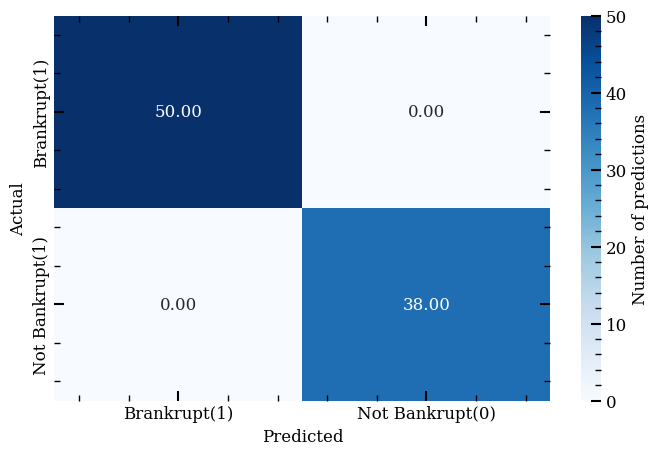

In [33]:
# Now on validation set
y_pred_test = rf.predict(X_test)
metrics_score(y_test, y_pred_test, 'Brankrupt', 'Not Bankrupt')

Both training and validation sets have been completely learned. This can potentially cause overfitting with a new and large dataset, further training and tuning would be preferential. 

Let us look how Random Forest ranks our feature importances

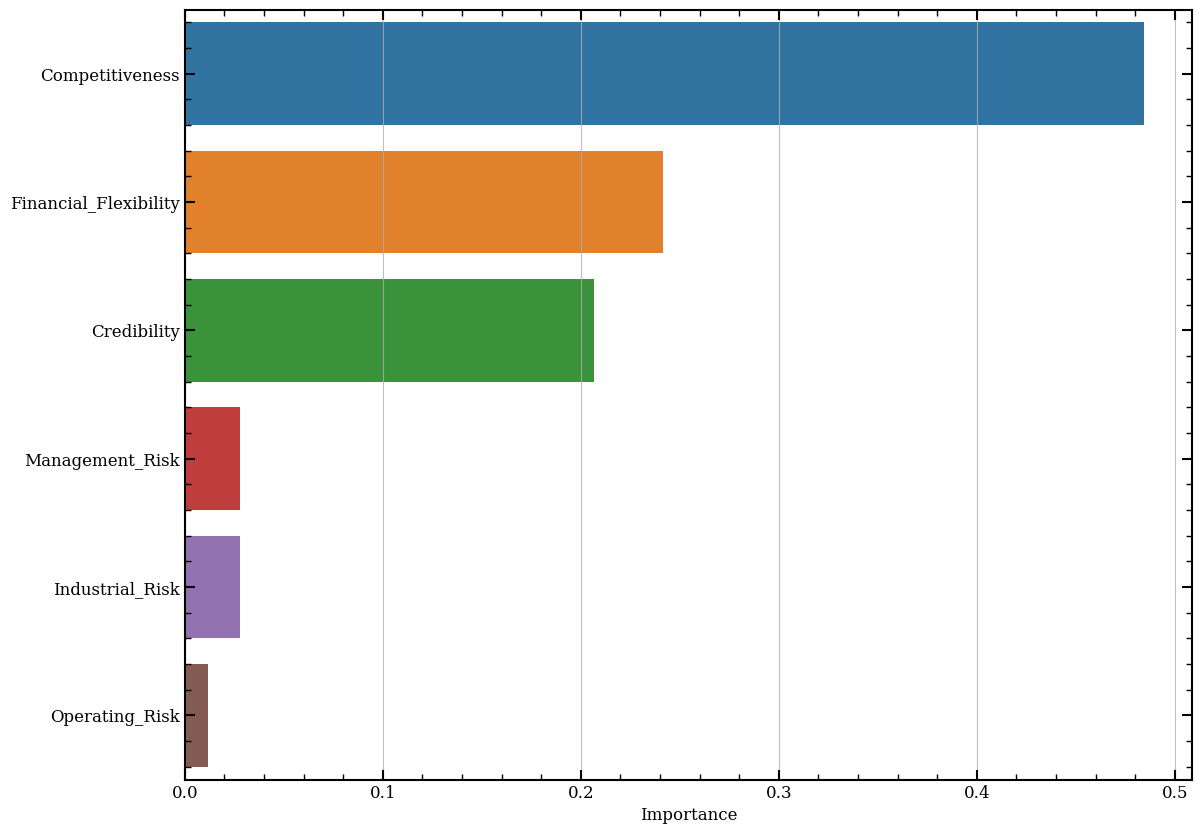

In [34]:
importances = rf.feature_importances_
columns = X.columns

importance_df_temp = pd.DataFrame(importances, 
                                  index = columns, 
                                  columns = ['Importance'])

importance_df = importance_df_temp.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 10))
sns.barplot(x = importance_df.Importance, y = importance_df.index)
plt.show()

Random Forest suggests, **Competitiveness, Financial Flexibility and Credibility** are our three most importaint features

As mentioned, we seem to know our training and validation set very well when predicting Bankruptcy for this problem. Exposure to a larger training set can help in tuning and generalization.

I will try one more algorithm but overall we do not expect to perform better on the test dataset.

### Model 2: Logistic Regression with Threshold

In [35]:
# Fitting logistic regression model
lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        93
           1      1.000     1.000     1.000        69

    accuracy                          1.000       162
   macro avg      1.000     1.000     1.000       162
weighted avg      1.000     1.000     1.000       162



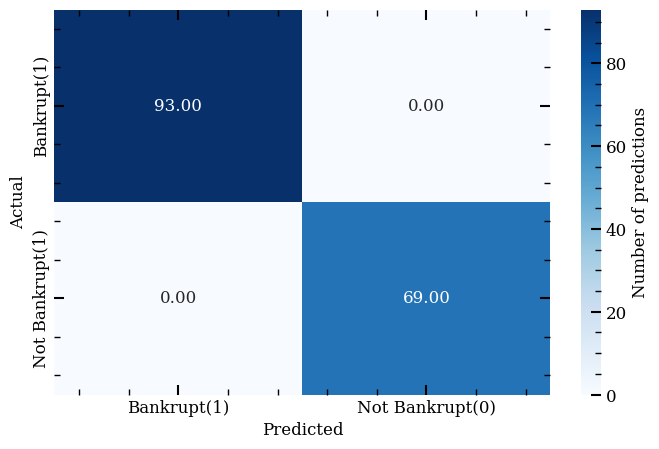

In [36]:
# Checking the performance on the training data
y_pred_train = lg.predict(X_train)
metrics_score(y_train, y_pred_train, 'Bankrupt', 'Not Bankrupt')

Once again we have completely learned our training data

              precision    recall  f1-score   support

           0      0.980     1.000     0.990        50
           1      1.000     0.974     0.987        38

    accuracy                          0.989        88
   macro avg      0.990     0.987     0.988        88
weighted avg      0.989     0.989     0.989        88



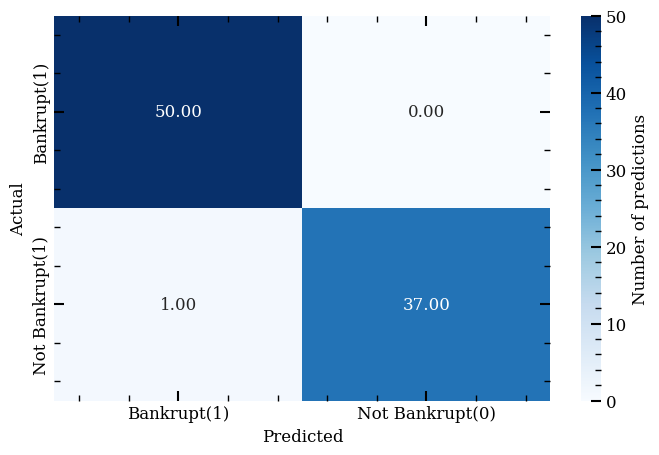

In [37]:
# Checking the performance on the test dataset
y_pred_test = lg.predict(X_test)
metrics_score(y_test, y_pred_test, 'Bankrupt', 'Not Bankrupt')

Good performance on test set again, let us look for an optimal threshold for precision-recall

#### **Finding the optimal threshold for the model using the Precision-Recall Curve:**

Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

Using the Precision-Recall curve we can see if we can find a **better threshold.**


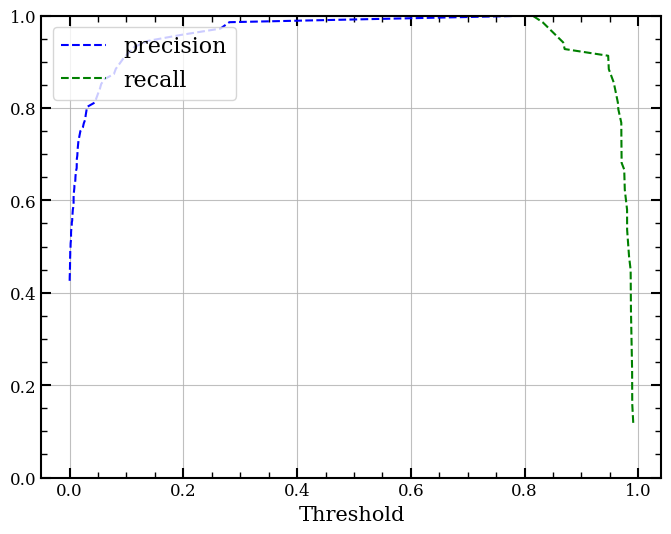

In [38]:
from sklearn.metrics import precision_recall_curve
y_scores_lg=lg.predict_proba(X_train)

# The 2nd y_scores_lg column predicts higher probabilities for Bankruptcy (i.e. --> 1)
precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(8,6))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold', fontsize = 15)
plt.legend(loc='upper left', fontsize = 16 )
plt.ylim([0,1])
plt.show()

In [39]:
# The optimal threshold
print(' The optimal threshod is: ', 
      round(thresholds_lg[np.where(precisions_lg >= recalls_lg)[0][0]],3))

 The optimal threshod is:  0.814


              precision    recall  f1-score   support

           0      1.000     1.000     1.000        93
           1      1.000     1.000     1.000        69

    accuracy                          1.000       162
   macro avg      1.000     1.000     1.000       162
weighted avg      1.000     1.000     1.000       162



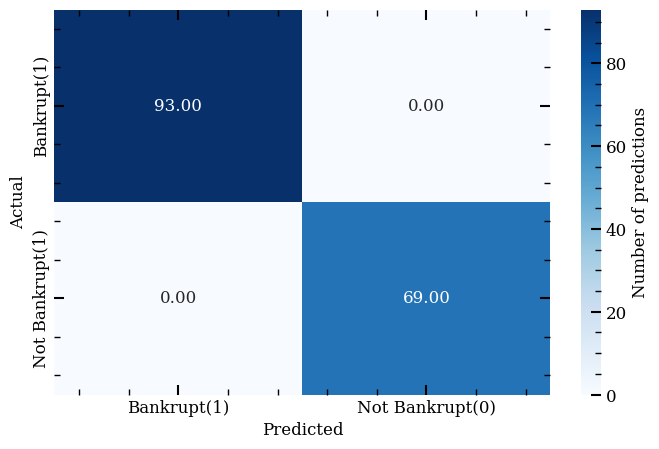

In [40]:
optimal_threshold = 0.814
y_pred_train = lg.predict_proba(X_train)
metrics_score(y_train, y_pred_train[:,1] > optimal_threshold, 'Bankrupt', 'Not Bankrupt')

We have now completely learned and predicted our training and validation set once again. Let us look at the structure of the regression model:

In [41]:
lg.coef_, lg.intercept_

(array([[-0.19367399, -0.61803065, -1.8133093 , -1.40625156, -2.51742115,
         -0.21445303]]),
 array([11.48088129]))

Writing out our linear logistic regression model:

$$ \mathrm{logit}(\mathrm{P}_i) = \sum_j{\beta_jX^i_j} = -\big(0.19X_1 + 0.62X_2 + 1.81X_3 + 1.41X_4 + 2.52X_5 + 0.21X_6 \big) + 11.5 $$

and written in terms of each probability:

$$ \mathrm{P}(0|X) = \big(1 + e^{\sum_j{\beta_jX_j}}\big)^{-1}$$

$$ \mathrm{P}(1|X) = \big(1 + e^{-\sum_j{\beta_jX_j}}\big)^{-1}$$

It appears our most importaint features to consider for predicting bankruptcy are: 

$X_3=$ Financial Flexibility

$X_4=$ Credibility


$X_5=$ Competitiveness


# END